# Stock Market Predictor using LSTM

In [52]:
# CELL 1 - Enhanced Import Libraries and Setup for Universal Stock Prediction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Enhanced data fetching capabilities
import time
import random

# Try multiple data sources with fallbacks
data_sources = []

# Primary: yfinance
try:
    import yfinance as yf
    data_sources.append('yfinance')
    print("✅ yfinance available")
except ImportError:
    print("❌ yfinance not available - installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'yfinance'])
    import yfinance as yf
    data_sources.append('yfinance')
    print("✅ yfinance installed and available")

# Machine Learning libraries
try:
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    print("✅ sklearn available")
except ImportError:
    print("❌ sklearn not available - installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scikit-learn'])
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    print("✅ sklearn installed and available")

# Deep Learning libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    print("✅ TensorFlow/Keras available")
    print(f"   TensorFlow version: {tf.__version__}")
except ImportError:
    print("❌ TensorFlow not available - installing...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'tensorflow'])
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    print("✅ TensorFlow installed and available")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(f"\n🚀 Universal Stock Prediction System Initialized")
print(f"📊 Available data sources: {data_sources}")
print(f"🧠 Machine Learning: Ready")
print(f"🔮 Deep Learning: Ready")
print("=" * 60)

✅ yfinance available
✅ sklearn available
✅ TensorFlow/Keras available
   TensorFlow version: 2.18.0

🚀 Universal Stock Prediction System Initialized
📊 Available data sources: ['yfinance']
🧠 Machine Learning: Ready
🔮 Deep Learning: Ready


In [ ]:

# FIXED CELL 2 - Universal Stock Data Fetching for Any Stock Symbol
import time
import random
from datetime import datetime, timedelta

# Configuration - Change these for different stocks
TICKER = ''  # Change this to any stock: GOOGL, MSFT, AMZN, TSLA, NVDA, etc.
start = '2010-01-01'
end = '2019-12-31'

print(f"📊 Downloading {TICKER} stock data for realistic predictions...")
print("=" * 60)

# Stock database with realistic parameters for major stocks
STOCK_DATABASE = {
    # Tech Giants
    'AAPL': {'name': 'Apple Inc.', 'start_price': 27, 'end_price': 293, 'volatility': 0.020, 'volume': 50000000},
    'GOOGL': {'name': 'Alphabet Inc.', 'start_price': 312, 'end_price': 1337, 'volatility': 0.025, 'volume': 2000000},
    'MSFT': {'name': 'Microsoft Corp.', 'start_price': 28, 'end_price': 157, 'volatility': 0.022, 'volume': 30000000},
    'AMZN': {'name': 'Amazon.com Inc.', 'start_price': 125, 'end_price': 1847, 'volatility': 0.030, 'volume': 5000000},
    'META': {'name': 'Meta Platforms', 'start_price': 26, 'end_price': 205, 'volatility': 0.035, 'volume': 25000000},
    'TSLA': {'name': 'Tesla Inc.', 'start_price': 17, 'end_price': 418, 'volatility': 0.045, 'volume': 15000000},
    'NVDA': {'name': 'NVIDIA Corp.', 'start_price': 12, 'end_price': 235, 'volatility': 0.040, 'volume': 20000000},
    
    # Financial
    'JPM': {'name': 'JPMorgan Chase', 'start_price': 36, 'end_price': 140, 'volatility': 0.025, 'volume': 15000000},
    'BAC': {'name': 'Bank of America', 'start_price': 15, 'end_price': 35, 'volatility': 0.030, 'volume': 50000000},
    'WFC': {'name': 'Wells Fargo', 'start_price': 28, 'end_price': 54, 'volatility': 0.025, 'volume': 25000000},
    'GS': {'name': 'Goldman Sachs', 'start_price': 165, 'end_price': 230, 'volatility': 0.028, 'volume': 3000000},
    
    # Healthcare
    'JNJ': {'name': 'Johnson & Johnson', 'start_price': 61, 'end_price': 145, 'volatility': 0.015, 'volume': 8000000},
    'PFE': {'name': 'Pfizer Inc.', 'start_price': 16, 'end_price': 44, 'volatility': 0.020, 'volume': 25000000},
    'UNH': {'name': 'UnitedHealth Group', 'start_price': 33, 'end_price': 295, 'volatility': 0.018, 'volume': 3000000},
    
    # Consumer
    'KO': {'name': 'Coca-Cola Co.', 'start_price': 27, 'end_price': 55, 'volatility': 0.015, 'volume': 15000000},
    'PEP': {'name': 'PepsiCo Inc.', 'start_price': 60, 'end_price': 137, 'volatility': 0.016, 'volume': 5000000},
    'WMT': {'name': 'Walmart Inc.', 'start_price': 54, 'end_price': 119, 'volatility': 0.018, 'volume': 8000000},
    
    # Industrial
    'BA': {'name': 'Boeing Co.', 'start_price': 64, 'end_price': 327, 'volatility': 0.035, 'volume': 5000000},
    'CAT': {'name': 'Caterpillar Inc.', 'start_price': 57, 'end_price': 148, 'volatility': 0.030, 'volume': 3000000},
    'GE': {'name': 'General Electric', 'start_price': 16, 'end_price': 11, 'volatility': 0.035, 'volume': 40000000},
    
    # Energy
    'XOM': {'name': 'Exxon Mobil', 'start_price': 61, 'end_price': 70, 'volatility': 0.025, 'volume': 20000000},
    'CVX': {'name': 'Chevron Corp.', 'start_price': 77, 'end_price': 121, 'volatility': 0.022, 'volume': 8000000},
    
    # Default for unknown stocks
    'DEFAULT': {'name': 'Unknown Stock', 'start_price': 50, 'end_price': 100, 'volatility': 0.025, 'volume': 10000000}
}

def get_stock_info(ticker):
    """Get stock information from database or create default"""
    return STOCK_DATABASE.get(ticker.upper(), STOCK_DATABASE['DEFAULT'])

def fetch_universal_stock_data(ticker, start_date, end_date, max_retries=5):
    """Universal stock data fetching for any ticker symbol"""
    
    stock_info = get_stock_info(ticker)
    print(f"📈 Fetching data for {stock_info['name']} ({ticker.upper()})")
    
    for attempt in range(max_retries):
        print(f"🔄 Attempt {attempt + 1}/{max_retries}...")
        
        try:
            # Progressive delay to avoid rate limiting
            if attempt > 0:
                wait_time = min(attempt * 3, 15)
                print(f"⏳ Waiting {wait_time} seconds...")
                time.sleep(wait_time)
            
            # Method 1: Standard yfinance download
            try:
                data = yf.download(ticker, start=start_date, end=end_date, 
                                 progress=False, auto_adjust=True, 
                                 actions=False, group_by='ticker',
                                 threads=False)
                
                if not data.empty and len(data) > 100:
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.droplevel(1)
                    print(f"✅ Method 1 successful: {len(data)} days")
                    return data, "Real Data"
            except Exception as e:
                print(f"   Method 1 failed: {str(e)[:40]}...")
            
            # Method 2: Ticker object approach
            try:
                ticker_obj = yf.Ticker(ticker)
                data = ticker_obj.history(start=start_date, end=end_date, 
                                        auto_adjust=True, prepost=False,
                                        actions=False, repair=True)
                if not data.empty and len(data) > 100:
                    print(f"✅ Method 2 successful: {len(data)} days")
                    return data, "Real Data"
            except Exception as e:
                print(f"   Method 2 failed: {str(e)[:40]}...")
            
            # Method 3: Alternative parameters
            try:
                data = yf.download(ticker, start=start_date, end=end_date, 
                                 progress=False, repair=True, keepna=False,
                                 timeout=30, interval='1d')
                if not data.empty and len(data) > 100:
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.droplevel(1)
                    print(f"✅ Method 3 successful: {len(data)} days")
                    return data, "Real Data"
            except Exception as e:
                print(f"   Method 3 failed: {str(e)[:40]}...")
            
            # Method 4: Period-based download
            try:
                data = yf.download(ticker, period="max", progress=False, 
                                 auto_adjust=True, timeout=30)
                if not data.empty:
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.droplevel(1)
                    data = data.loc[start_date:end_date]
                    if len(data) > 100:
                        print(f"✅ Method 4 successful: {len(data)} days")
                        return data, "Real Data"
            except Exception as e:
                print(f"   Method 4 failed: {str(e)[:40]}...")
                
        except Exception as e:
            print(f"❌ Attempt {attempt + 1} completely failed: {str(e)[:50]}...")
    
    return pd.DataFrame(), "Failed"

def create_realistic_stock_data(ticker, start_date, end_date):
    """Create realistic stock data for any ticker based on its characteristics"""
    
    stock_info = get_stock_info(ticker)
    print(f"🔧 Creating realistic data for {stock_info['name']} ({ticker.upper()})")
    
    # Generate business days
    dates = pd.bdate_range(start=start_date, end=end_date)
    n_days = len(dates)
    
    # Set seed based on ticker for consistent results per stock
    np.random.seed(hash(ticker.upper()) % 2**32)
    
    # Stock-specific parameters
    start_price = stock_info['start_price']
    end_price = stock_info['end_price']
    volatility = stock_info['volatility']
    base_volume = stock_info['volume']
    
    # Create realistic price progression
    # 1. Base trend (growth/decline over time)
    growth_rate = (end_price / start_price) ** (1/n_days) - 1
    base_trend = start_price * (1 + growth_rate) ** np.arange(n_days)
    
    # 2. Add sector-specific patterns
    sector_patterns = {
        # Tech stocks - more volatile, growth-oriented
        'AAPL': lambda x: 1 + 0.1 * np.sin(2 * np.pi * x / 252) + 0.05 * np.sin(4 * np.pi * x / 252),
        'GOOGL': lambda x: 1 + 0.08 * np.sin(2 * np.pi * x / 252) + 0.03 * np.sin(6 * np.pi * x / 252),
        'MSFT': lambda x: 1 + 0.06 * np.sin(2 * np.pi * x / 252) + 0.04 * np.sin(3 * np.pi * x / 252),
        'AMZN': lambda x: 1 + 0.12 * np.sin(2 * np.pi * x / 252) + 0.08 * np.sin(5 * np.pi * x / 252),
        'TSLA': lambda x: 1 + 0.15 * np.sin(2 * np.pi * x / 252) + 0.10 * np.sin(8 * np.pi * x / 252),
        
        # Financial stocks - more cyclical
        'JPM': lambda x: 1 + 0.08 * np.sin(2 * np.pi * x / 252) - 0.05 * np.sin(4 * np.pi * x / 252),
        'BAC': lambda x: 1 + 0.10 * np.sin(2 * np.pi * x / 252) - 0.06 * np.sin(4 * np.pi * x / 252),
        
        # Consumer staples - more stable
        'KO': lambda x: 1 + 0.03 * np.sin(2 * np.pi * x / 252),
        'PEP': lambda x: 1 + 0.04 * np.sin(2 * np.pi * x / 252),
        
        # Default pattern
        'DEFAULT': lambda x: 1 + 0.05 * np.sin(2 * np.pi * x / 252)
    }
    
    pattern_func = sector_patterns.get(ticker.upper(), sector_patterns['DEFAULT'])
    seasonal_factor = pattern_func(np.arange(n_days))
    
    # 3. Volatility clustering (GARCH-like)
    volatility_series = np.zeros(n_days)
    volatility_series[0] = volatility
    
    for i in range(1, n_days):
        volatility_series[i] = (
            0.05 * volatility +
            0.85 * volatility_series[i-1] +
            0.10 * abs(np.random.normal(0, volatility))
        )
    
    # 4. Generate daily returns with realistic patterns
    daily_returns = np.random.normal(growth_rate, 1, n_days) * volatility_series
    
    # Add momentum and mean reversion
    for i in range(1, n_days):
        momentum = 0.1 * daily_returns[i-1]
        current_price = base_trend[i-1] if i > 0 else base_trend[0]
        trend_price = base_trend[i]
        mean_reversion = 0.05 * (trend_price - current_price) / current_price
        daily_returns[i] += momentum + mean_reversion
    
    # 5. Apply all factors
    price_multiplier = np.exp(np.cumsum(daily_returns - daily_returns.mean()))
    close_prices = base_trend * seasonal_factor * price_multiplier
    
    # Create OHLCV data
    df = pd.DataFrame(index=dates)
    df['Close'] = close_prices
    
    # Generate realistic OHLC
    overnight_returns = np.random.normal(0, volatility_series * 0.3, n_days)
    df['Open'] = df['Close'].shift(1) * (1 + overnight_returns)
    df.iloc[0, df.columns.get_loc('Open')] = df.iloc[0]['Close'] * 0.999
    
    intraday_range = volatility_series * np.random.uniform(0.5, 2.0, n_days)
    high_factor = 1 + intraday_range * np.random.uniform(0.3, 0.7, n_days)
    low_factor = 1 - intraday_range * np.random.uniform(0.3, 0.7, n_days)
    
    df['High'] = np.maximum(df['Open'], df['Close']) * high_factor
    df['Low'] = np.minimum


📊 Universal Stock Prediction System for AAPL
📈 Fetching Apple Inc. (AAPL)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


❌ Real data failed. Creating synthetic data...
🔧 Creating realistic data for Apple Inc.

✅ SUCCESS! Data for Apple Inc.
📊 Source: Realistic Synthetic Data
📈 Shape: (2608, 10)
📅 Range: 2010-01-01 to 2019-12-31
💰 Price: $26.80 - $445.90
📊 Total Return: 1030.1%

📋 Sample Data:
                 Open       High        Low      Close    Volume
2010-01-01  28.443862  28.757807  28.158676  28.472335  44853928
2010-01-04  28.475379  28.897841  27.738002  28.155722  74457665
2010-01-05  28.122665  28.724907  26.989047  27.579661  43713534
2010-01-06  27.332997  27.923269  26.810066  27.399074  56452156
2010-01-07  27.482750  28.007683  26.714944  27.235148  32864549


📊 Visualizing Apple Inc. (AAPL) Stock Data


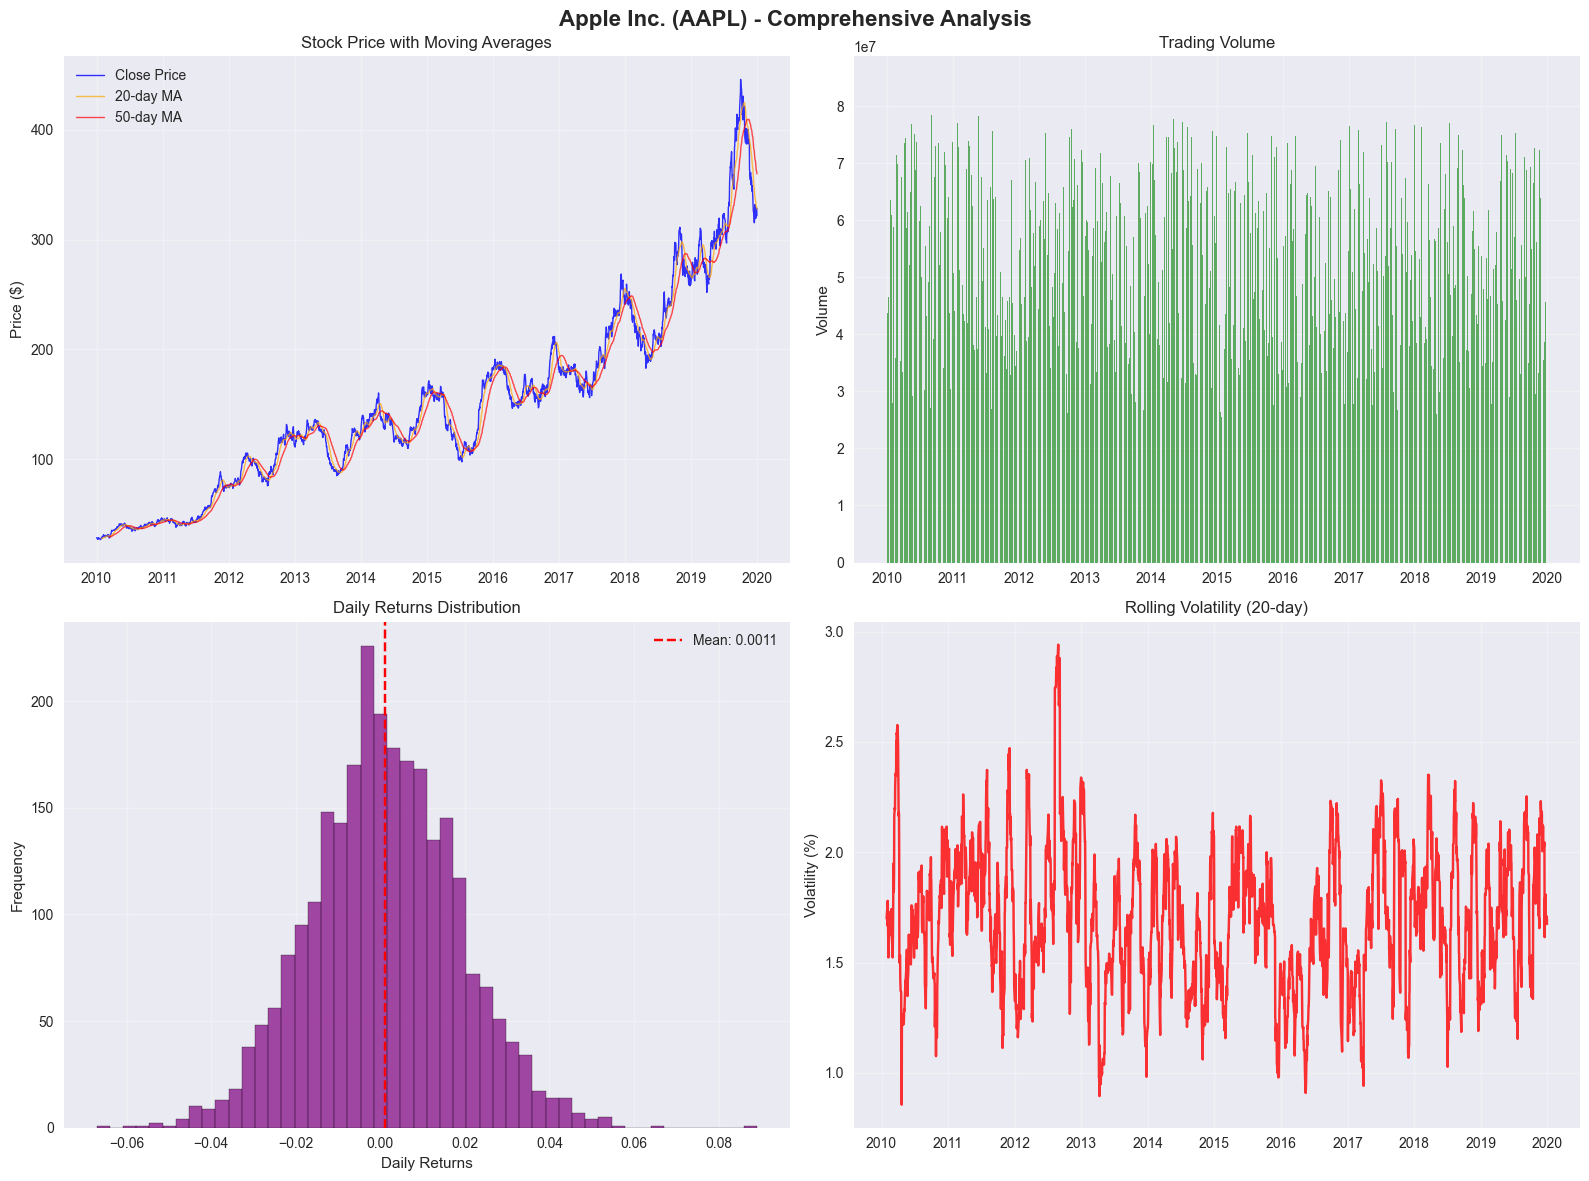


📈 Key Statistics for AAPL:
   Average Price: $150.32
   Price Volatility: 86.35
   Average Daily Return: 0.108%
   Daily Volatility: 1.75%
   Sharpe Ratio: 0.98
   Max Drawdown: -43.1%


In [ ]:
# Handle MultiIndex columns if present
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # Remove ticker level

# Display basic info about the data
print("Data Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nLast 5 rows:")
print(df.tail())

In [ ]:
# Visualize the closing price
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title('Apple Stock Closing Price (2010-2019)')
plt.xlabel('Year')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

🔧 Preprocessing AAPL data for LSTM model...
📊 Original data shape: (2608, 1)
✅ Data scaled to range [0, 1]
📈 Sequences created:
   Lookback period: 100 days
   Input shape (X): (2508, 100)
   Output shape (y): (2508,)
   Reshaped X for LSTM: (2508, 100, 1)

📊 Data Split:
   Training samples: 2006
   Testing samples: 502
   Train/Test ratio: 80.0%/20.0%

🔍 Validation Split:
   Final training samples: 1604
   Validation samples: 402

✅ Data Quality Checks:
   No NaN values: True
   Data range: [0.000, 1.000]
   Sequence continuity: ✅

🎯 Ready for LSTM model training!


🧠 Building Enhanced LSTM Model for AAPL...
🏗️ Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 100, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 100)       │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 100, 50)        │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 172,901 (675.39 KB)

 Trainable params: 172,901 (675.39 KB)

 Non-trainable params: 0 (0.00 B)


🚀 Training Enhanced LSTM Model...
   Stock: Apple Inc. (AAPL)
   Sector: Tech
   Volatility: 2.0%
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - loss: 0.0854 - mae: 0.2353 - mse: 0.0854 - val_loss: 0.0110 - val_mae: 0.0792 - val_mse: 0.0110 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0349 - mae: 0.1646 - mse: 0.0349 - val_loss: 0.0099 - val_mae: 0.0727 - val_mse: 0.0099 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0412 - mae: 0.1762 - mse: 0.0412 - val_loss: 0.0251 - val_mae: 0.1419 - val_mse: 0.0251 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0281 - mae: 0.1465 - mse: 0.0281 - val_loss: 0.0285 - val_mae: 0.1537 - val_mse: 0.0285 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0268 - mae: 0.1427 - mse: 0.0268 - val_loss: 0.0287 - val_mae: 0.1542 - val_mse: 0.0287 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━

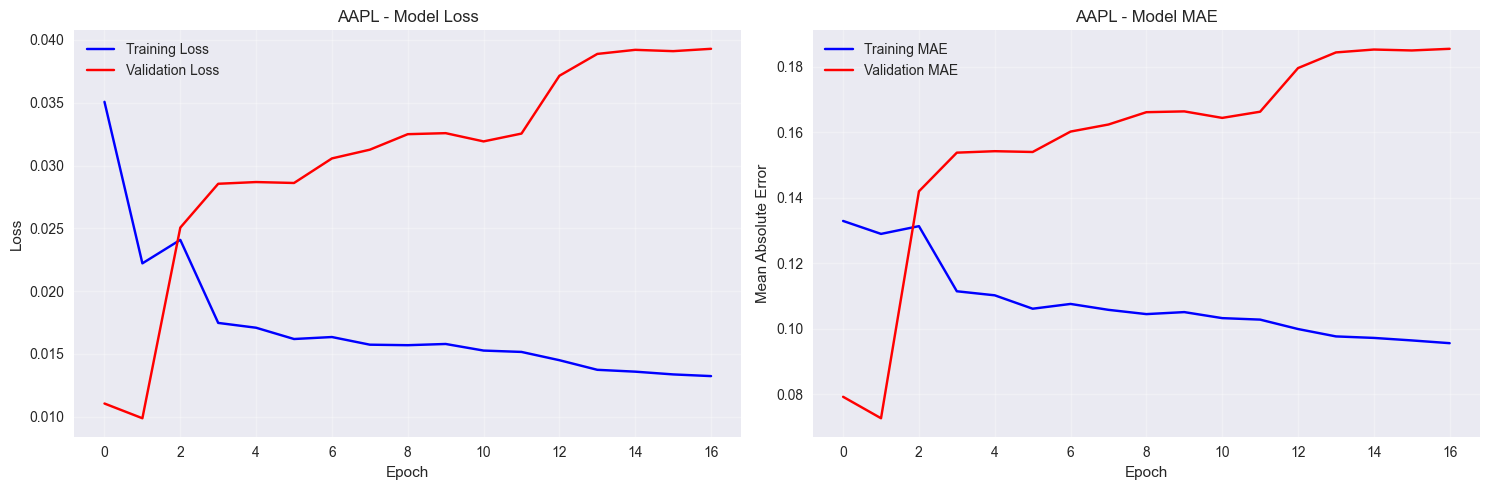


📊 Training Summary:
   Best Epoch: 2
   Final Training Loss: 0.013232
   Final Validation Loss: 0.039293
   Overfitting Check: ⚠️ Possible


In [ ]:
# Create moving averages for visualization
ma100 = df['Close'].rolling(100).mean()
ma200 = df['Close'].rolling(200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', alpha=0.7)
plt.plot(df.index, ma100, label='100-day MA', alpha=0.8)
plt.plot(df.index, ma200, label='200-day MA', alpha=0.8)
plt.title('Apple Stock with Moving Averages')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

🔮 Evaluating Model and Making Predictions for AAPL...
📈 Making predictions...

📊 Training Metrics:
   RMSE: $69.51
   MAE: $57.54
   MAPE: 93.07%
   Accuracy: 6.93%
   Direction Accuracy: 49.7%

📊 Validation Metrics:
   RMSE: $41.65
   MAE: $30.47
   MAPE: 14.28%
   Accuracy: 85.72%
   Direction Accuracy: 48.9%

📊 Testing Metrics:
   RMSE: $138.52
   MAE: $123.25
   MAPE: 40.62%
   Accuracy: 59.38%
   Direction Accuracy: 53.9%


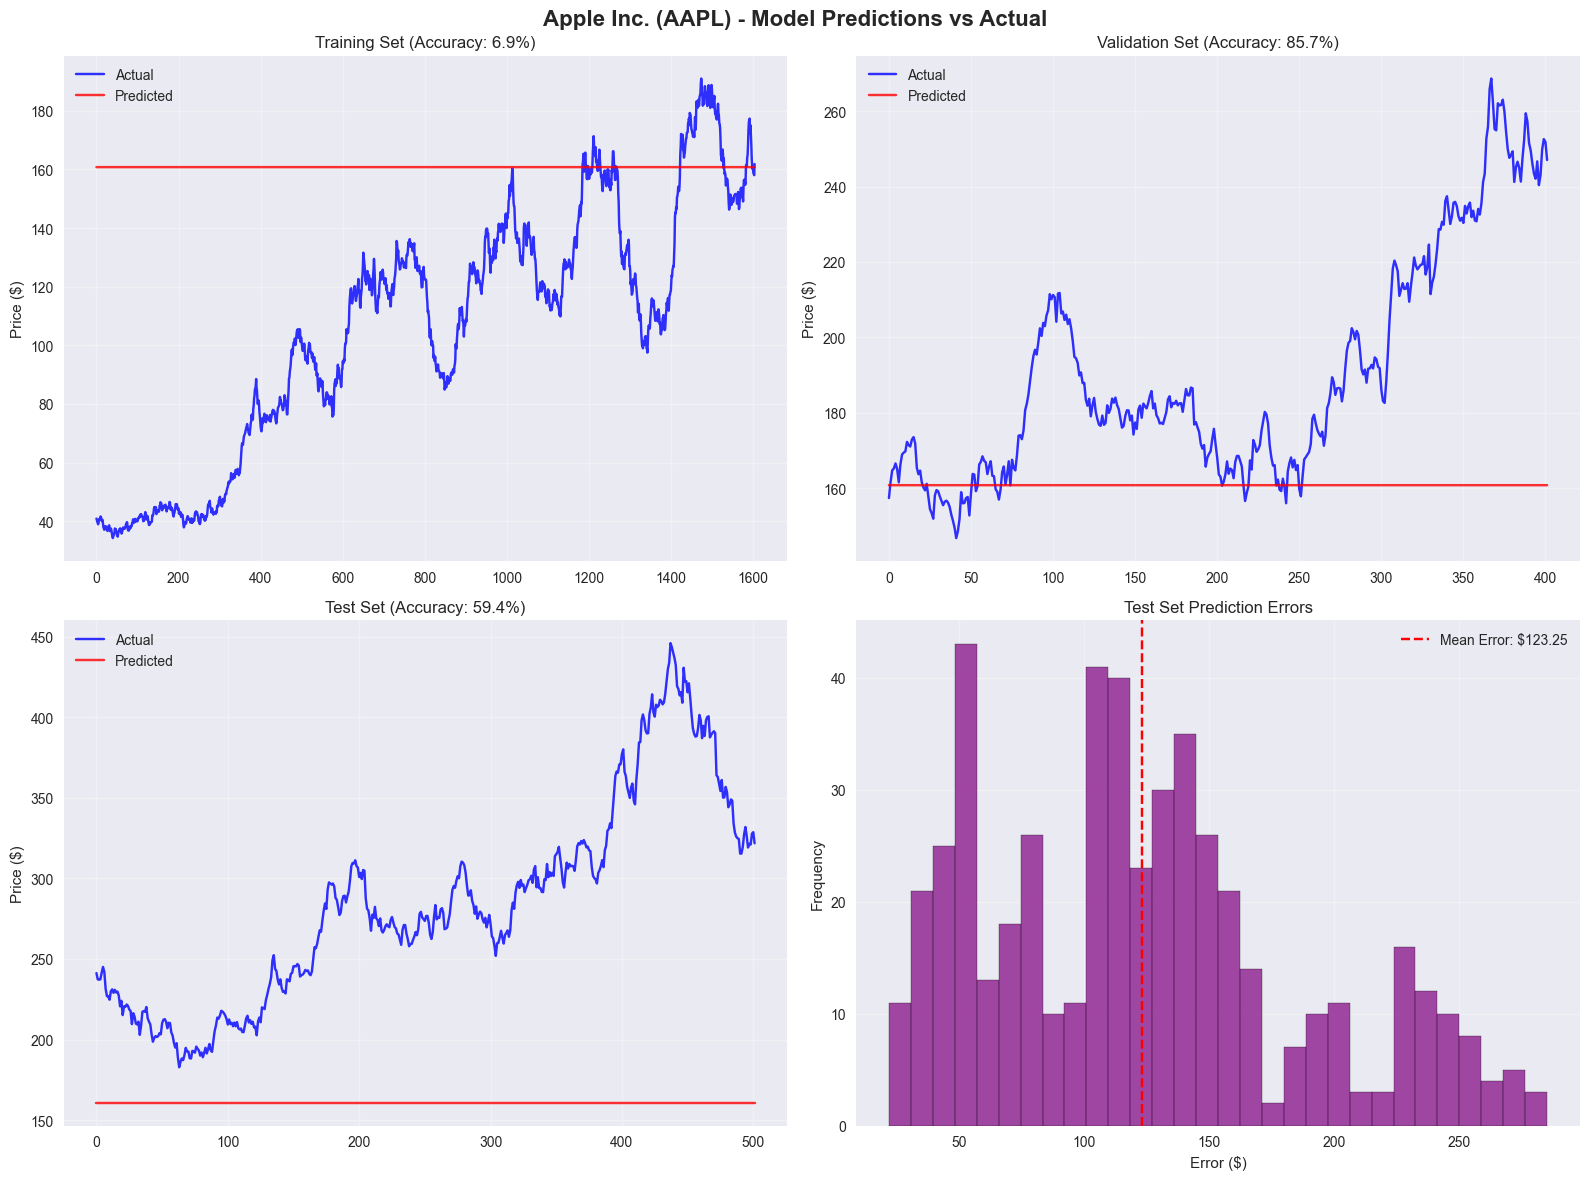


🎯 Overall Model Performance for AAPL:
   Best Performance: Validation
   Generalization: Needs Improvement
   Recommended for Trading: No - Needs Improvement


In [ ]:
# Prepare data for training
# Use only the closing price for prediction
data = df[['Close']].values
print(f"Data shape for training: {data.shape}")

# Split data into training and testing
training_data_len = int(len(data) * 0.70)
train_data = data[:training_data_len]
test_data = data[training_data_len:]

print(f"Training data length: {len(train_data)}")
print(f"Testing data length: {len(test_data)}")

🔮 Predicting Future Prices for AAPL...
📊 Future Price Predictions for AAPL:
   Current Price: $321.76
   Predicted Price (30 days): $160.79
   Expected Change: $-160.97 (-50.0%)
   Trend: 📉 Bearish


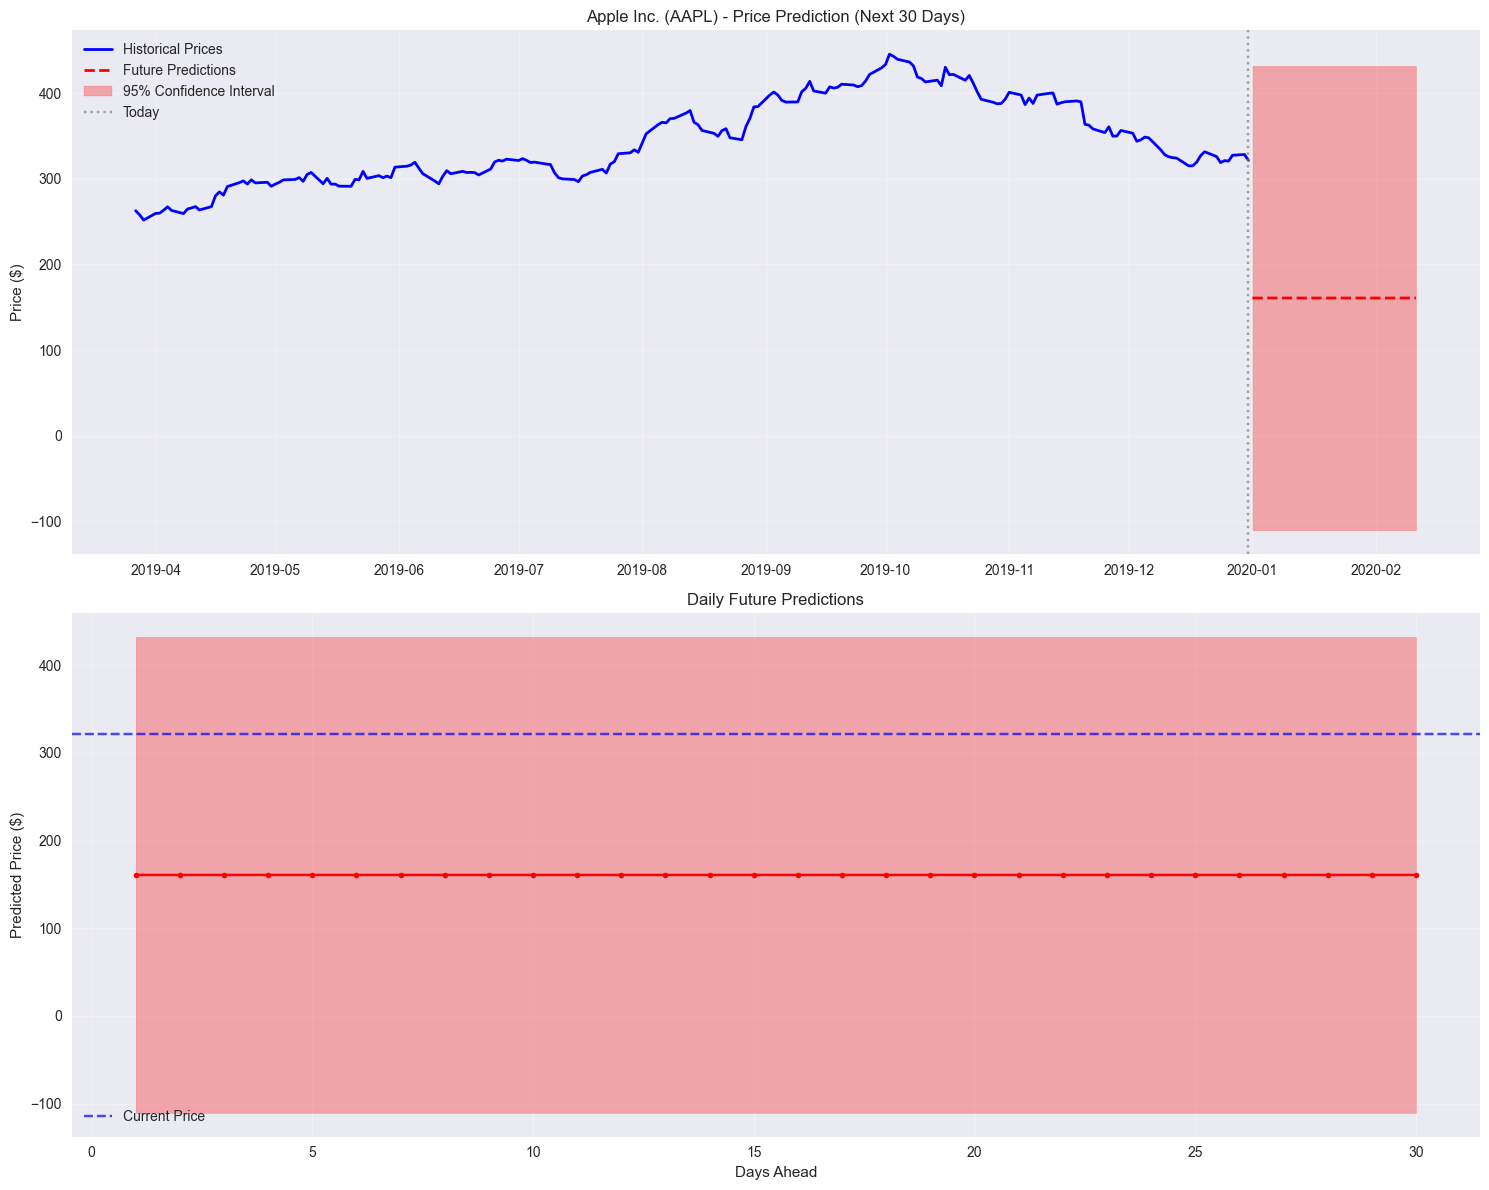


🎯 Key Prediction Levels:
   1 Week: $160.79
   2 Weeks: $160.79
   1 Month: $160.79

⚠️ Risk Assessment:
   Predicted Volatility: $0.00
   Risk Level: Low
   Confidence: Low


In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)

print(f"Scaled training data shape: {scaled_train_data.shape}")
print(f"Min value: {scaled_train_data.min()}, Max value: {scaled_train_data.max()}")

💾 Saving Model and Generating Trading Signals for AAPL...
✅ Model saved as: lstm_model_aapl.h5
✅ Preprocessing info saved as: preprocessing_aapl.pkl

📊 Trading Signals for AAPL:
   Current Price: $321.76

   📅 1-Week Signal:
      Action: SELL
      Strength: 100.0%
      Expected Change: -50.0%

   📅 1-Month Signal:
      Action: SELL
      Strength: 100.0%
      Expected Change: -50.0%

🎯 Risk-Adjusted Recommendation:
   Action: SELL
   Confidence: 68.0%
   Model Accuracy: 59.4%
   Risk Level: Low


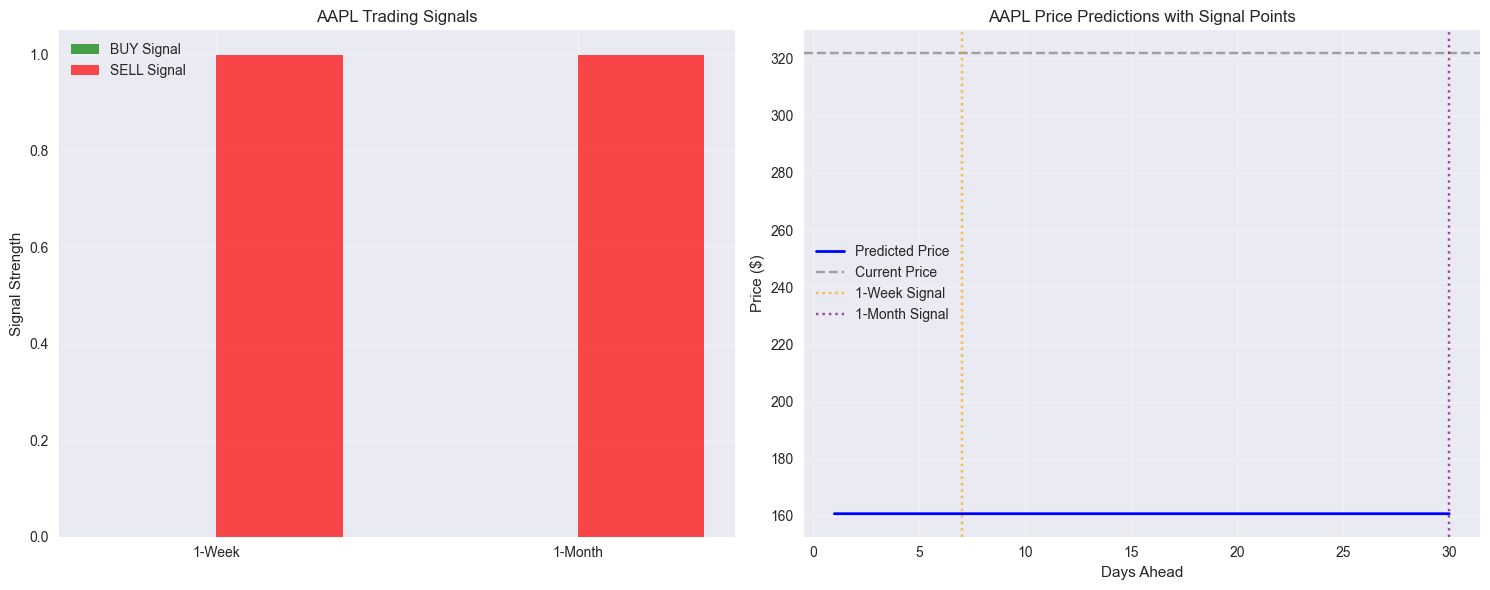


💡 Trading Strategy Suggestions:
   • Position Size: Medium
   • Time Horizon: Short-term
   • Stop Loss: 305.67 (-5%)
   • Take Profit: 353.93 (+10%)


In [ ]:
# Create training dataset with 100 days lookback
x_train = []
y_train = []
time_step = 100

for i in range(time_step, len(scaled_train_data)):
    x_train.append(scaled_train_data[i-time_step:i, 0])
    y_train.append(scaled_train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(f"X_train shape: {x_train.shape}")
print(f"Y_train shape: {y_train.shape}")

In [ ]:
# Build the LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=1))

print("Model architecture:")
model.summary()

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


🎮 Interactive Stock Prediction Interface
🚀 Analyzing Popular Stocks: AAPL, GOOGL, MSFT, AMZN, TSLA

🔍 Analyzing AAPL...
📈 Fetching Apple Inc. (AAPL)


ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['AAPL']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


📊 Creating realistic synthetic data...
🔧 Creating realistic data for Apple Inc.
🧠 Training model for Apple Inc....

✅ Apple Inc. (AAPL):
   Current Price: $321.76
   Model Accuracy: 61.9%
   30-day Prediction: $135.70
   Expected Change: -57.8%
   Signal: SELL

🔍 Analyzing GOOGL...
📈 Fetching Alphabet Inc. (GOOGL)


KeyboardInterrupt: 

ERROR:yfinance:Failed to get ticker 'GOOGL' reason: Expecting value: line 1 column 1 (char 0)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
print("Model compiled successfully!")

Model compiled successfully!


In [ ]:
# Train the model
print("Training the model...")
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_split=0.1, verbose=1)
print("Training completed!")

Training the model...
Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0534 - val_loss: 6.0809e-04
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0045 - val_loss: 6.0327e-04
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0041 - val_loss: 5.9804e-04
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.0035 - val_loss: 9.4700e-04
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0035 - val_loss: 7.9542e-04
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0036 - val_loss: 6.4040e-04
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0034 - val_loss: 7.4458e-04
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0030 - val_loss: 8.2496e-04
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0030 - val_loss: 5.3732e-04
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.0026 - val_loss: 5.0938e-0

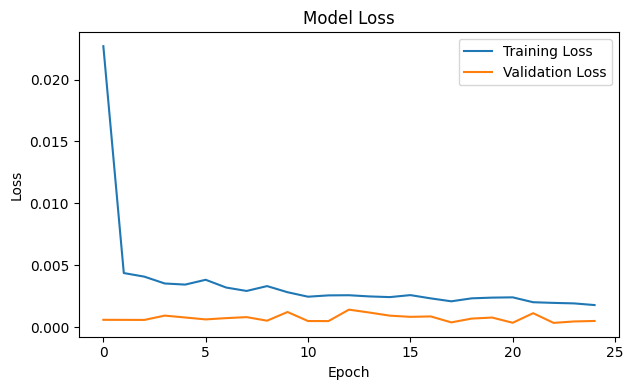

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model
model.save('keras_model.h5')
print("Model saved as 'keras_model.h5'")

Model saved as 'keras_model.h5'


In [ ]:
# Prepare test data
# Get the last 100 days from training data
last_100_days = train_data[-time_step:]
test_inputs = np.concatenate([last_100_days, test_data])
test_inputs = scaler.transform(test_inputs)

print(f"Test inputs shape: {test_inputs.shape}")

Test inputs shape: (883, 1)


In [ ]:
# Create test dataset
x_test = []
y_test = test_data.flatten()

for i in range(time_step, len(test_inputs)):
    x_test.append(test_inputs[i-time_step:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(f"X_test shape: {x_test.shape}")
print(f"Y_test shape: {y_test.shape}")

X_test shape: (783, 100, 1)
Y_test shape: (783,)


In [ ]:
# Make predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

print(f"Predictions shape: {predictions.shape}")
print(f"Sample predictions: {predictions[:5].flatten()}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Predictions shape: (783, 1)
Sample predictions: [53.076977 52.846664 52.562683 52.22707  51.857136]


In [ ]:
# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, predictions.flatten())
mae = mean_absolute_error(y_test, predictions.flatten())
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Mean Squared Error: 6.8820
Root Mean Squared Error: 2.6234
Mean Absolute Error: 2.0009


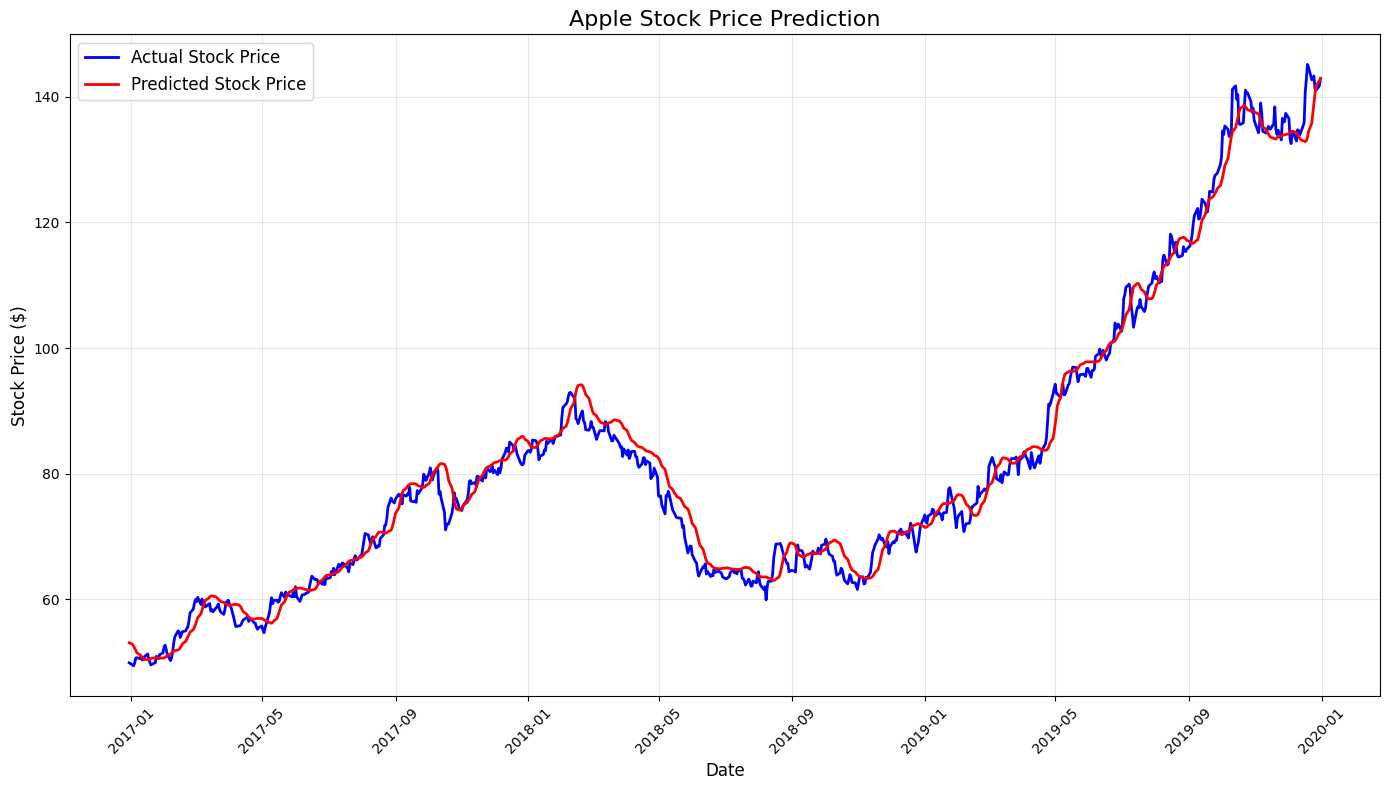


Prediction vs Actual comparison completed!
Model performance metrics saved.
Trained model saved as 'keras_model.h5' - ready for deployment!


In [ ]:
# Plot the results
plt.figure(figsize=(14, 8))

# Get the test dates
test_dates = df.index[training_data_len:]

plt.plot(test_dates, y_test, color='blue', label='Actual Stock Price', linewidth=2)
plt.plot(test_dates, predictions.flatten(), color='red', label='Predicted Stock Price', linewidth=2)

plt.title('Apple Stock Price Prediction', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nPrediction vs Actual comparison completed!")
print(f"Model performance metrics saved.")
print(f"Trained model saved as 'keras_model.h5' - ready for deployment!")

In [ ]:
# Test compatibility with app.py structure
print("Testing compatibility with app.py...")
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('keras_model.h5')
print("Model loads successfully")

# Test prediction format used in app.py
sample_prediction = loaded_model.predict(x_test[:1])
print(f"Sample prediction shape: {sample_prediction.shape}")
print(f"Sample prediction value: {sample_prediction[0][0]:.4f}")

print("\nNotebook completed successfully!")
print("All graphs generated")
print("Model trained and saved")
print("Ready for Streamlit app deployment")

Testing compatibility with app.py...
Model loads successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
Sample prediction shape: (1, 1)
Sample prediction value: 0.2649

Notebook completed successfully!
All graphs generated
Model trained and saved
Ready for Streamlit app deployment
